In [301]:
import re
import mdtraj as md
import mdfeature.features as features
import numpy as np
import dill
import os, glob
from mdfeature.ConvergenceAnalyser import free_energy_estimate_2D
import pyemma
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
import pydiffmap.diffusion_map as dfm
import mdfeature.features as features
from time import time
import mdtraj
from pyemma.coordinates.data.featurization.angles import DihedralFeature

In [302]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
font = {'family' : 'sans-serif',
        'size'   : 14.0}
mpl.rc('font', **font) 
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] =  16
mpl.rcParams['font.size'] =  15
mpl.rcParams['figure.autolayout'] =  True
mpl.rcParams['figure.figsize'] =  7.2,4.45
mpl.rcParams['axes.titlesize'] =  16
mpl.rcParams['axes.labelsize'] =  17
mpl.rcParams['lines.linewidth'] =  2
mpl.rcParams['lines.markersize'] =  6
mpl.rcParams['legend.fontsize'] =  13

Define Experiment Class

In [702]:
import openmm.unit as unit

unit_labels = {
    "us": unit.microseconds,
    "ns": unit.nanoseconds,
    "ps": unit.picoseconds,
    "fs": unit.femtoseconds
}


def parse_quantity(s):
    try:
        u = s.lstrip('0123456789.')
        v = s[:-len(u)]
        return unit.Quantity(
            float(v),
            unit_labels[u]
        )
    except Exception:
        raise ValueError(f"Invalid quantity: {s}")
        
def subsample_trajectory(trajectory, stride):
    traj = md.Trajectory(trajectory.xyz[::stride], trajectory.topology)
    return traj.superpose(traj[0]) 

def check_and_remove_nans(data, axis=1):
    num_nans = np.count_nonzero(np.isnan(data)) 
    if num_nans > 0:
        axis_str = "rows" if axis==1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]
        
    return data


    
class Experiment:
    
    #TODO: fix bug when default torsions = None

        def __init__(self, location, dihedral_pickle_file, temperature, duration, savefreq, stepsize, default_torsions=None):
            self.pdb = self.load_pdb(location)
            self.topology = self.pdb.topology
            self.trajectory = self.load_trajectory(location, self.topology)
            self.dihedral_traj = self.load_dihedral_trajectory(location, dihedral_pickle_file)
            assert len(self.trajectory) > 0, "Trajectory is empty."
            assert len(self.dihedral_traj) > 0, "Dihedral trajectory is empty."
            print("Successfully loaded experiment data.")
            
            self.temperature = temperature
            self.duration = parse_quantity(duration)
            self.savefreq = parse_quantity(savefreq)
            self.stepsize = parse_quantity(stepsize)
            self.iterations = int(self.duration / self.stepsize)
            self.beta = 1/(self.temperature*0.0083144621)
            self.conformations = len(self.trajectory)
            assert np.abs(self.conformations - int(self.duration/self.savefreq)) <= 1, f"duration ({duration}) and savefreq ({savefreq}) incompatible with number of conformations found in trajectory (got {self.conformations}, expected {int(self.duration/self.savefreq)})."
            print("Successfully initialised experiment metadata.")
            
            self.featurizer = self.initialise_featurizer(default_torsions)
            self.featurized_trajectory = self.featurizer.transform(self.trajectory)
            self.mean_features = np.mean(self.featurized_trajectory, axis=0)
            self.fluctuations_features = np.std(self.featurized_trajectory, axis=0)
            print("Successfully featurized trajectory.")

            self.PCA = None
            self.TICA = None
            self.VAMP = None
            self.kre = KramersRateEvaluator()
            self.kre_params = {'minimum_counts':25,'bins':200,'impute_free_energy_nans':True,
                               'cluster_type':'kmeans','k':100,'ignore_high_energy_minima':False,
                              'include_endpoint_minima':True,'minima_prominence':1.5,'options':None}
            self.dmap = dfm.DiffusionMap.from_sklearn(epsilon = 'bgh', alpha = 0.5, k=64, kernel_type='gaussian', n_evecs=5, neighbor_params=None,
                             metric='euclidean', metric_params=None, weight_fxn=None, density_fxn=None, bandwidth_type="-1/(d+2)",
                             bandwidth_normalize=False, oos='nystroem')
            self.discrete_traj = None

        @staticmethod
        def load_pdb(loc):
            pdb_files = glob.glob(os.path.join(loc, '*.pdb'))
            assert len(pdb_files) <= 1, f"Read error: more than one PDB file found in the directory ({pdb_files})."
            assert len(pdb_files) != 0, f"Read error: no PDB files found in directory."
            return md.load_pdb(pdb_files[0])
        
        @staticmethod
        def load_trajectory(loc, topology):
            traj_files = glob.glob(os.path.join(loc, '*.dcd'))
            assert len(traj_files) <= 1, f"Read error: more than one traj file found in the directory ({traj_files})."
            assert len(traj_files) != 0, f"Read error: no traj files found in directory."
            return mdtraj.load(traj_files[0], top=topology)
        
        @staticmethod
        def load_dihedral_trajectory(loc, dihedral_pickle_file):
            dihedral_traj = np.array(dill.load(open(os.path.join(loc,dihedral_pickle_file), "rb"))).T
            # correcting order
            dihedral_traj[:,[0, 1]] = dihedral_traj[:,[1, 0]]
            return dihedral_traj
        
        def initialise_featurizer(self, default_torsions):
            featurizer = pyemma.coordinates.featurizer(self.topology)
            dihedral_indices = features.create_torsions_list(atoms=self.topology.n_atoms, size=0, append_to=default_torsions, print_list=False)
            featurizer.add_dihedrals(dihedral_indices, cossin=True)
            return featurizer

        def ramachandran_plot(self, bins=100, nan_threshold=50, rotate=False):
            dihedral_traj = check_and_remove_nans(self.dihedral_traj)
            free_energy, xedges, yedges = free_energy_estimate_2D(dihedral_traj, self.beta, bins=bins)
            fig, ax = plt.subplots()
            if rotate is True:
                free_energy = free_energy.T
            im = ax.pcolormesh(xedges, yedges, np.ma.array(free_energy, mask=(free_energy > nan_threshold)))
            plt.colorbar(im)
            plt.xlabel(r'$\phi$')
            plt.ylabel(r'$\psi$')
            plt.gca().set_aspect('equal')
            plt.show()
            
        def implied_timescale_analysis(self, max_lag=10, k=10):
            if self.discrete_traj is None:
                cluster = pyemma.coordinates.cluster_kmeans(self.featurized_trajectory, k=k)
                self.discrete_traj = cluster.dtrajs[0]
            its = pyemma.msm.its(self.discrete_traj, lags=max_lag)
            pyemma.plots.plot_implied_timescales(its)


        def compute_PCA(self, dim, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.PCA = pyemma.coordinates.pca(trajectory, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed PCA in {round(t1-t0,3)}s.")

        def compute_TICA(self, dim, lag, stride=1, featurized=True, kinetic_map=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.TICA = pyemma.coordinates.tica(trajectory, lag=lag, dim=dim, stride=stride, kinetic_map=kinetic_map)
            t1 = time()
            print(f"Computed TICA in {round(t1-t0,3)}s.")

        def compute_VAMP(self, dim, lag, stride=1, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.VAMP = pyemma.coordinates.vamp(trajectory, lag=lag, dim=dim, stride=stride)
            t1 = time()
            print(f"Computed VAMP in {round(t1-t0,3)}s.")
                
        def compute_DMAP(self, stride, featurized=True):
            t0 = time()
            trajectory = self.featurized_trajectory if featurized else self.trajectory
            self.DMAP = self.dmap.fit(trajectory[::stride])
            t1 = time()
            print(f"Computed DMAP in {round(t1-t0,3)}s.")
                
        def analyse_PCA(self, dimension, lag, sigmaD, sigmaF):
            assert self.PCA is not None, "Run compute_PCA before analyse_PCA."
            self.kre.fit(self.PCA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize,
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def analyse_TICA(self, dimension, lag, sigmaD, sigmaF):
            assert self.TICA is not None, "Run compute_TICA before analyse_TICA."
            self.kre.fit(self.TICA.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
        
        def analyse_VAMP(self, dimension, lag, sigmaD, sigmaF):
            assert self.VAMP is not None, "Run compute_VAMP before analyse_VAMP."
            self.kre.fit(self.VAMP.get_output()[0][:,dimension], beta = self.beta, time_step = self.stepsize, 
                         lag = lag, sigmaD = sigmaD, sigmaF = sigmaF, **self.kre_params)
            
        def eigenvector(self, CV: str, dim: int):
            self._assert_valid_cv(CV)
            x = None
            if CV == 'PCA':
                x = self.PCA.get_output()[0][:,dim]
            elif CV == 'VAMP':
                x = self.VAMP.get_output()[0][:,dim]
            elif CV == 'DMAP':
                x = self.DMAP.evecs[:,dim]
                print(x)
                print(x.shape)
            elif CV == 'TICA':
                return self.TICA.eigenvectors[:,dim]
            return self._lstsq_traj_with_features(traj=x)
        
        def _lstsq_traj_with_features(self, traj):
            a = self.featurized_trajectory
            a = np.c_[np.ones(self.conformations), a]  
            c, err, _, _ = np.linalg.lstsq(a, traj, rcond=None)
            
            return c[1:]
        
        def _assert_valid_cv(self, CV: str):
            assert CV in ['PCA', 'TICA', 'VAMP', 'DMAP'], "CV must be one of PCA, TICA, VAMP, DMAP."
            if CV == 'PCA':
                assert self.PCA is not None, "Run compute_PCA first."
            elif CV == 'TICA':
                assert self.TICA is not None, "Run compute_TICA first."
            elif CV == 'VAMP':
                assert self.VAMP is not None, "Run compute_VAMP first."
            elif CV == 'DMAP':
                assert self.DMAP is not None, "Run compute_DMAP first."

        def create_plumed_metadynamics_script(self, CV: str, filename=None, gaussian_height=0.2, gaussian_pace=1000):
            self._assert_valid_cv(CV)
            f = open("./plumed.py" if filename is None else f"./{filename}.py", 'w')
            output = "plumed_script=\"RESTART " + "\\n\\"
            f.write(output + "\n")
            print(output)
            dihedral_features = Dihedrals(dihedrals=self.featurizer.active_features, 
                                          offsets=self.mean_features, 
                                          coefficients=self.eigenvector(CV, dim=0))
            dihedral_features.write_torsion_labels(file=f)
            dihedral_features.write_transform_labels(file=f)
            dihedral_features.write_combined_label(CV=CV, file=f)
            self._write_metadynamics_line(height=gaussian_height, pace=gaussian_pace, CV=CV, file=f)
            
        def _write_metadynamics_line(self, height, pace, CV, file):
            arg_list = []
            sigma_list = []
            arg_list.append(f"{CV}_%d" % 0)
            sigma_list.append(str(0.1))
            output = "METAD ARG=%s SIGMA=%s HEIGHT=%s FILE=HILLS PACE=%s LABEL=metad" \
                     % (','.join(arg_list), ','.join(sigma_list), \
                        str(height), str(pace)) + " \\n\\"
            print(output)
            file.writelines(output + "\n")
            output = "PRINT ARG=%s,metad.bias STRIDE=%s FILE=COLVAR" % (','.join(arg_list), str(pace)) + " \\n"
            print(output + "\"")
            file.writelines(output + "\"" + "\n")
            file.close()




Tasks to do

2) TICA with and without Dihedral Featurizer
3) OpenMM metadynamics - in what form do the collective variables need to be given?
5) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in ring double well
6) Diffusion maps vs. TICA vs. VAMPnet trajectories Kramers Rate in alanine dipeptide

4) Learn collective variables from 20ns alanine dipeptide trajectory

In [680]:
#pdb_file = '../data/alanine.pdb'
#trajectory = '../data/outputs/alanine_20ns/trajectory.dcd'
location = '../data/outputs/alanine_20ns'
dihedral_pickle_file = 'alanine_20ns_dihedral_traj.pickle'
temperature = 300
duration = "20ns" 
savefreq = "0.1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_20ns = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully loaded experiment data.
Successfully initialised experiment metadata.
Successfully featurized trajectory.


6 NaNs detected, removing rows with NaNs.


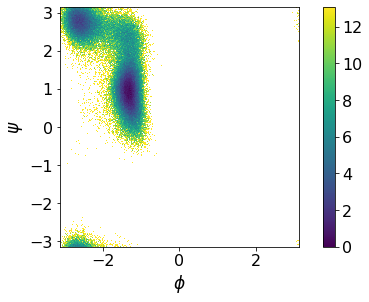

In [533]:
alanine_exp_20ns.ramachandran_plot(rotate=True, bins=300)

In [732]:
location = '../data/outputs/alanine_1us'
dihedral_pickle_file = 'alanine_1us_dihedral_traj.pickle'
temperature = 300
duration = "987.036ns" 
savefreq = "1ps"
stepsize = "2fs"
phi = [4, 6, 8 ,14] #dihedral coordinates
psi = [6, 8, 14, 16]
zeta = [1, 4, 6, 8]
theta = [8, 14, 16, 18]
default_torsions = [phi, psi, zeta, theta]
alanine_exp_1us = Experiment(location = location, 
                              dihedral_pickle_file = dihedral_pickle_file,
                              temperature = temperature,
                              duration = duration,
                              savefreq = savefreq,
                              stepsize = stepsize,
                              default_torsions=default_torsions
                              )

Successfully loaded experiment data.
Successfully initialised experiment metadata.
Successfully featurized trajectory.


In [ ]:
alanine_exp_1us.compute_PCA(dim = 3, stride=1)
alanine_exp_1us.compute_TICA(dim = 3, lag=64, stride=1)
alanine_exp_1us.compute_VAMP(dim = 3, lag=64, stride=1)
alanine_exp_1us.compute_DMAP(stride=1)

Computed PCA in 0.056s.
Computed TICA in 0.145s.
Computed VAMP in 0.137s.


28 NaNs detected, removing rows with NaNs.


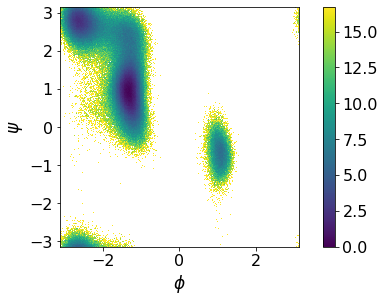

In [10]:
alanine_exp_1us.ramachandran_plot(rotate=False, bins=300)

In [10]:
alanine_exp_20ns.compute_DMAP(stride=1)
alanine_exp_1us.compute_DMAP(stride=5)

Computed DMAP in 1797.133s.
Computed DMAP in 2514.815s.


In [11]:
dill.dump(alanine_exp_20ns, file=open("alanine_exp_20ns.pickle", "wb"))
dill.dump(alanine_exp_1us, file=open("alanine_exp_1us.pickle", "wb"))

In [17]:
print(len(alanine_exp_1us.DMAP.dmap))

197408


In [614]:
class Dihedral:
    
    def __init__(self, atom_indices, residue_indices, sincos, offset, idx: int):
        self.atom_indices = atom_indices
        self.residue_indices = residue_indices
        self.sincos = sincos
        self.offset = offset
        self.idx = idx
        #self.str_index = str(int(np.floor(self.idx/2)))
        self.dihedral_label_trig_removed = "_".join([str(s+1) for s in atom_indices])
        self.dihedral_label = str(self.sincos)+"_"+self.dihedral_label_trig_removed
    
    def torsion_label(self):
        # plumed is 1 indexed and mdtraj is not
        if self.sincos == "sin": #only output one torsion label per sin-cos pair
            return "TORSION ATOMS="+",".join(str(i+1) for i in self.atom_indices)+F" LABEL={self.dihedral_label_trig_removed} \\n\\"
        else:
            return None
    
    def transformer_label(self):
        return f"MATHEVAL ARG={self.dihedral_label_trig_removed} FUNC={self.sincos}(x)-{self.offset} LABEL={self.dihedral_label} PERIODIC=NO \\n\\"
        
        

class Dihedrals:
    
    def __init__(self, dihedrals: DihedralFeature, offsets: list[float], coefficients: list[float]):
        # TODO: init with coefficients 
        self.dihedral_list = []
        self.dihedral_labels = []
        self.coefficients = [str(v) for v in coefficients]
        self.initialise_lists(dihedrals[0], offsets)
            
    def parse_dihedral_string(self, txt: str):
        num_seq = np.array([int(s) for s in re.findall(r'\b\d+\b', txt)])
        if "SIN" in txt and "COS" not in txt:
            sincos = "sin"
        elif "COS" in txt and "SIN" not in txt:
            sincos = "cos"
        else:
            raise ValueError(f"Expected either SIN or COS in string, got {txt}.")
        atom_indices =  num_seq[1::2] 
        residue_indices = num_seq[0::2]
        return atom_indices, residue_indices, sincos
    
    def initialise_lists(self, dihedrals, offsets):
        dihedral_labels = dihedrals.describe()
        assert len(dihedral_labels) == len(offsets), "The number of offets must equal the number of dihedrals."
        for idx, label in enumerate(dihedral_labels):
            atom_indices, residue_indices, sincos = self.parse_dihedral_string(label)
            dihedral = Dihedral(atom_indices, residue_indices, sincos, offsets[idx], idx)
            self.dihedral_list.append(dihedral)
            self.dihedral_labels.append(dihedral.dihedral_label)
            
    def write_torsion_labels(self, file):
        for dihedral in self.dihedral_list:
            output = dihedral.torsion_label() 
            if output is not None:
                print(output)
                file.writelines(output+'\n')
            
    def write_transform_labels(self, file):
        for dihedral in self.dihedral_list:
            output = dihedral.transformer_label() 
            print(output)
            file.writelines(output+'\n')
            
    def write_combined_label(self, CV, file):
        output = f"COMBINE LABEL={CV}_0"+f" ARG={','.join(self.dihedral_labels)}" + f" COEFFICIENTS={','.join(self.coefficients)}" + " PERIODIC=NO" + " \\n\\" 
        print(output)
        file.writelines(output+'\n')

estimating MaximumLikelihoodMSM:   0%|                                                                        …

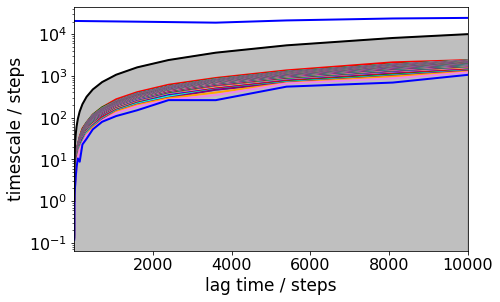

In [707]:
alanine_exp_1us.implied_timescale_analysis(max_lag=10000, k=100)

Computed TICA in 0.16s.
Computed TICA in 0.139s.
Computed TICA in 0.141s.
Computed TICA in 0.138s.
Computed TICA in 0.138s.
Computed TICA in 0.134s.
Computed TICA in 0.147s.
Computed TICA in 0.143s.
Computed TICA in 0.137s.
Computed TICA in 0.139s.
Computed TICA in 0.143s.
Computed TICA in 0.13s.
Computed TICA in 0.136s.
Computed TICA in 0.135s.


/tmp/ipykernel_5968/2906940858.py:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


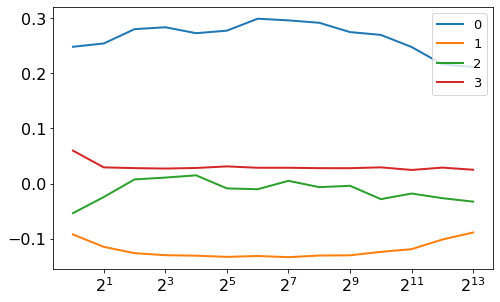

In [727]:
eig0=[]
eig1=[]
eig2=[]
eig3=[]
eig4=[]
lags = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
for lag in lags:
    alanine_exp_1us.compute_TICA(lag=lag, dim=1)
    eig = alanine_exp_1us.eigenvector('TICA', dim=0)
    eig0.append(eig[4])
    eig1.append(eig[5])
    eig2.append(eig[6])
    eig3.append(eig[7])
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.plot(lags, eig0, label='0')
ax.plot(lags, eig1, label='1')
ax.plot(lags, eig2, label='2')
ax.plot(lags, eig3, label='3')
ax.legend()

In [731]:
#alanine_exp_1us.compute_DMAP(stride=1000)
alanine_exp_1us.create_plumed_metadynamics_script(CV='PCA')

plumed_script="RESTART \n\
TORSION ATOMS=5,7,9,15 LABEL=5_7_9_15 \n\
TORSION ATOMS=7,9,15,17 LABEL=7_9_15_17 \n\
TORSION ATOMS=2,5,7,9 LABEL=2_5_7_9 \n\
TORSION ATOMS=9,15,17,19 LABEL=9_15_17_19 \n\
MATHEVAL ARG=5_7_9_15 FUNC=cos(x)--0.018100298941135406 LABEL=cos_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=5_7_9_15 FUNC=sin(x)--0.7750170826911926 LABEL=sin_5_7_9_15 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=cos(x)-0.11455978453159332 LABEL=cos_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=7_9_15_17 FUNC=sin(x)-0.5776147246360779 LABEL=sin_7_9_15_17 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=cos(x)--0.9876720905303955 LABEL=cos_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=2_5_7_9 FUNC=sin(x)--0.0018686018884181976 LABEL=sin_2_5_7_9 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=cos(x)--0.9883973598480225 LABEL=cos_9_15_17_19 PERIODIC=NO \n\
MATHEVAL ARG=9_15_17_19 FUNC=sin(x)--0.004300905857235193 LABEL=sin_9_15_17_19 PERIODIC=NO \n\
COMBINE LABEL=PCA_0 ARG=cos_5_7_9_15,sin_5_7_9_15,cos_7_9_15_17,sin_7_9_15_

In [634]:
alanine_exp_1us.fluctuations_features

array([0.48558477, 0.40551752, 0.7119853 , 0.38256413], dtype=float32)

In [651]:
vamp_md = Experiment('../CSD3scripts/outputs/production_alanine_amber_175730_160722/', 'alanine_1.5ns_VAMP_dihedral_traj.pickle', 300, '1.5ns', '1ps', '2fs', default_torsions = [phi, psi, zeta, theta])

Successfully loaded experiment data.
Successfully initialised experiment metadata.
Successfully featurized trajectory.


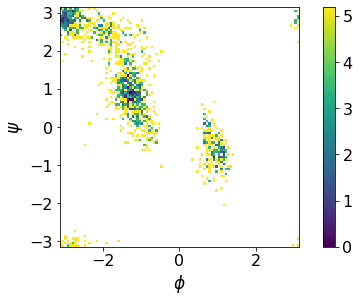

In [652]:
vamp_md.ramachandran_plot(rotate=True)